In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate
from scipy.stats import norm

from tropical_cyclone_dm import TropicalCycloneSequenceDataModule

plt.rcParams["figure.figsize"] = [14, 5]

color_palette = {
    # "MVEClassification": "#1f77b4",  # Blue
    # "QuantileClassification": "#ff7f0e",  # Orange
    "DKLClassification": "#2ca02c",  # Green
    "LaplaceClassification": "#d62728",  # Red
    "DeepEnsembleClassification": "#9467bd",  # Purple
    "MCDropoutClassification": "#8c564b",  # Brown
    "SWAGClassification": "#e377c2",  # Pink
    "BNN_VI_ELBO_Classification": "#7f7f7f",  # Gray
    "DER": "#bcbd22",  # Lime
    "DUEClassification": "#17becf",  # Teal
    "DeterministicClassification": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDClassification": "#98df8a",
    "TempScaling": "#ff9896",  # Light Red
}

VAR_TO_PLOT_LABEL = {
    "mae": "MAE",
    "rmse": "RMSE",
    "pred_uct": "Pred. Uncertainty",
    "coverage": "Coverage",
    "sharpness": "Sharpness",
    "calibration": "Calibration",
    "correlation": "Correlation",
    "nll": "NLL",
    "mace": "MACE",
    "crps": "CRPS",
    "proportion_in_0.9_interval": "Proportion in 0.9 Interval",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "H1": "Cat 1 Hurricane",
    "H2": "Cat 2 Hurricane",
    "H3": "Cat 3 Hurricane",
    "H4": "Cat 4 Hurricane",
    "H5": "Cat 5 Hurricane",
    "DKLClassification": "DKL",
    "LaplaceClassification": "Laplace",
    "DeepEnsembleClassification": "Deep Ensemble",
    "MCDropoutClassification": "MC Dropout",
    "SWAGClassification": "SWAG",
    "BNN_VI_ELBO_Classification": "BNN VI ELBO",
    "DUEClassification": "DUE",
    "DeterministicClassification": "Deterministic",
    "CARDClassification": "CARD",
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    "/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34",
    #"/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0",
    # "/p/project/hai_uqmethodbox/experiment_output/keep_class_min_speed_0",
    # "/p/project/hai_uqmethodbox/experiment_output/test_class_digital",
    #"/p/project/hai_uqmethodbox/experiment_output/test_class_kl_div",
    # "/p/project/hai_uqmethodbox/experiment_output/test_class",
    # "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new",
]
paths = [
    file
    for directory in directories
    for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))
    if os.path.exists(os.path.join(os.path.dirname(file), "config.yaml"))
]


# selective prediction threshold
SELECTIVE_THRESH = 12

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "absolute"

# TODO map them to readable names
STORM_DISPLAY_ORDER = ["all", "TD", "TS", "H1", "H2", "H3", "H4", "H5"]

DS_SPLIT = "test"


UQ_METHOD_DISPLAY_ORDER = [
    "DeterministicClassification",
    "DeepEnsembleClassification",
    "MCDropoutClassification",
    "SWAGClassification",
    "LaplaceClassification",
    "BNN_VI_ELBO_Classification",
    "DKLClassification",
    "DUEClassification",
    "CARDClassification",
]

# Define the groups
UQ_METHOD_GROUPS = {
    "Bayesian": [
        "MCDropoutClassification",
        "SWAGClassification",
        "LaplaceClassification",
        "BNN_VI_ELBO_Classification",
        "DKLClassification",
        "DUEClassification",
    ],
    "Ensemble": ["DeepEnsembleClassification"],
    "Diffusion": ["CARDClassification"],
}

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_DeepEnsembleClassification_03-02-2024_09-44-29-331747/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_DeepEnsembleClassification_03-02-2024_09-44-29-331747/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_DeepEnsembleClassification_03-02-2024_09-44-29-331747/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_TempScaling_03-02-2024_09-44-29-331739/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_TempScaling_03-02-2024_09-44-29-331739/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_TempScaling_03-02-2024_09-44-29-331739/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_DeterministicClassification_03-01-2024_17-44-04-307662/preds_val.csv',
 '/p/proj

In [4]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        try:
            conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        except FileNotFoundError:
            print(f"Config not found for {path}")
            continue
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]

        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, "%m-%d-%Y")
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = re.sub(r"preds_.*\.csv", "config.yaml", path)
        exp_dict["metric_path"] = os.path.join(
            os.path.dirname(path), "csv_logs", "version_0", "metrics.csv"
        )
        conf = OmegaConf.load(exp_dict["conf_path"])
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df


overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
1,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
2,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
3,TempScaling,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
4,TempScaling,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
5,TempScaling,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
6,DeterministicClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
7,DeterministicClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
8,DeterministicClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
9,DUEClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...


In [5]:
with pd.option_context("display.max_colwidth", None):
    display(overview_df.conf_path)

0      /p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_DeepEnsembleClassification_03-02-2024_09-44-29-331747/config.yaml
1      /p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_DeepEnsembleClassification_03-02-2024_09-44-29-331747/config.yaml
2      /p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_DeepEnsembleClassification_03-02-2024_09-44-29-331747/config.yaml
3                     /p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_TempScaling_03-02-2024_09-44-29-331739/config.yaml
4                     /p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_TempScaling_03-02-2024_09-44-29-331739/config.yaml
5                     /p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_TempScaling_03-02-2024_09-44-29-331739/config.yaml
6     /p/project/hai_uqmethodbox/experiment_output/test_class_digital_34/cyclone_DeterministicClassification_03-

In [6]:
datamodule = instantiate(OmegaConf.load(overview_df.conf_path.iloc[0]).datamodule)
datamodule.setup("fit")
datamodule.setup(stage="test")

In [7]:
dataset = datamodule.dataset
train_ds = datamodule.train_dataset
val_ds = datamodule.val_dataset
test_ds = datamodule.test_dataset
calib_ds = datamodule.calibration_dataset

print(len(dataset)), print(len(train_ds)), print(len(val_ds)), print(
    len(calib_ds)
), print(len(test_ds))
ds = datamodule.test_dataset
WIND_SPEED_BINS = ds.wind_speed_bins

DS_DICT = {"train": dataset, "val": dataset, "test": test_ds}
print(WIND_SPEED_BINS)

101343
64500
14031
2801
20011


AttributeError: 'Subset' object has no attribute 'wind_speed_bins'

In [ ]:
bin_intervals = np.diff(WIND_SPEED_BINS)
bin_intervals = (np.append(bin_intervals, bin_intervals[-1]) / 2) + WIND_SPEED_BINS
bin_intervals, len(bin_intervals)

(array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
         47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
         92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
        137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
        182.5, 187.5]),
 38)

In [ ]:
import pandas as pd

from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm import trange, tqdm
from joblib import Parallel, delayed


# Define a function to fit a Gaussian
def fit_gaussian(x, mean, std_dev):
    return norm.pdf(x, mean, std_dev)


def fit_gaussian_to_row(row, bin_midpoints):
    p0 = [np.mean(row), np.std(row) + 1e-5]
    try:
        popt, _ = curve_fit(fit_gaussian, bin_midpoints, row, p0=p0, maxfev=2000)
    except RuntimeError:
        print(row)
        print(bin_midpoints)
    return popt


def process_overview_df(overview_df):
    overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]

    all_test_pred_df = []
    for idx, row in overview_df.iterrows():
        pred_df = pd.read_csv(row["pred_path"])
        pred_df["uqmethod"] = row["uqmethod"]
        if row["split"] == "preds.csv":
            pred_df["split"] = "preds_test"
        else:
            pred_df["split"] = row["split"].split(".")[0]

        pred_df["pred_path"] = row["pred_path"]
        all_test_pred_df.append(pred_df)

    all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)

    # all_test_pred_df = all_test_pred_df[(all_test_pred_df["uqmethod"] == "DKLClassification") & (all_test_pred_df["split"] == "preds_test")]

    # date
    pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

    # Extract dates and create a new column
    all_test_pred_df["date"] = all_test_pred_df["pred_path"].str.extract(pattern)

    # Convert the new_date_column to datetime format
    all_test_pred_df["date"] = pd.to_datetime(
        all_test_pred_df["date"], format="%m-%d-%Y_%H-%M"
    )

    def compute_bin_mean_prediction(x, bin_edges):
        # x = row["pred"]
        if x < len(bin_edges) - 1:
            return (bin_edges[x] + bin_edges[x + 1]) / 2
        else:
            # extend the last category bin
            return (bin_edges[x] + dataset.class_bin_size) / 2

    # argmax Classification prediction
    conditions = ["Classification", "TempScaling"]
    pattern = "|".join(conditions)
    if any(all_test_pred_df["pred_path"].str.contains(pattern)):
        # argmax Classification prediction
        all_test_pred_df["argmax_reg"] = all_test_pred_df.apply(
            lambda row: (
                compute_bin_mean_prediction(int(row["pred"]), WIND_SPEED_BINS)
                if any(condition in row["uqmethod"] for condition in conditions)
                else np.nan
            ),
            axis=1,
        )

        # weighted softmax Classification prediction
        logit_cols = [
            col for col in all_test_pred_df.columns if col.startswith("logit_")
        ]

        # Compute softmax values for each logit
        exp_logits = all_test_pred_df.loc[
            all_test_pred_df["uqmethod"].str.contains(pattern), logit_cols
        ].values.copy()
        softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

        # Compute bin intervals
        bin_intervals = np.diff(WIND_SPEED_BINS) / 2
        bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

        # Compute weighted average of the softmax over the logits
        all_test_pred_df.loc[
            all_test_pred_df["uqmethod"].str.contains(pattern), "softmax_weighted_reg"
        ] = np.sum(softmax_values * bin_midpoints, axis=1)

    # all_test_pred_df['argmax_reg'] = all_test_pred_df.apply(lambda row: compute_bin_mean_prediction(row, WIND_SPEED_BINS), axis=1)

    # # weighted softamx Classification prediction
    # logit_cols = [col for col in all_test_pred_df.columns if col.startswith('logit_')]

    # # Compute softmax values for each logit
    # exp_logits = np.exp(all_test_pred_df[logit_cols].values.copy())
    # softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # # Compute bin intervals
    # bin_intervals = np.diff(WIND_SPEED_BINS) / 2
    # bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

    # # Compute weighted average of the softmax over the logits
    # all_test_pred_df['softmax_weighted_reg'] = np.sum(softmax_values * bin_midpoints, axis=1)

    # logits = all_test_pred_df[logit_cols].values

    # logits_softplus = np.log1p(np.exp(logits))
    # logits_softplus_sum = np.sum(logits_softplus, axis=1, keepdims=True)
    # # logits_softplus_normalized = logits_softplus / logits_softplus_sum
    # logits_softplus_sum += 1e-3

    # # Fit a Gaussian to the softmax logits
    # gaussian_params = Parallel(n_jobs=12)(delayed(fit_gaussian_to_row)(row, np.arange(len(logit_cols))) for row in tqdm(logits_softplus_sum, desc="Fitting Gaussians"))
    # # Convert the list of tuples into a DataFrame
    # gaussian_params_df = pd.DataFrame(gaussian_params, columns=['gaussian_mean', 'gaussian_std'])

    # # # Assign the columns of the DataFrame to new columns in all_test_pred_df
    # all_test_pred_df[['gaussian_mean', 'gaussian_std']] = gaussian_params_df

    all_test_pred_df = all_test_pred_df.reset_index(drop=True)

    return all_test_pred_df


all_test_pred_df = process_overview_df(overview_df)
all_test_pred_df

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,logit_36,logit_37,uqmethod,split,pred_path,relative_time,ocean,date,argmax_reg,softmax_weighted_reg
0,5,1.190447,5,nkd,34356,25,-7.853996,-7.498690,-7.753402,1.351465,...,-7.768348,-7.289484,SWAGClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,27.5,129.237349
1,7,1.534693,7,aya,2398,35,-8.909798,-8.659307,-8.899755,-0.869892,...,-9.196141,-8.472114,SWAGClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,37.5,130.152778
2,5,0.865020,5,cjx,5222,25,-6.600438,-6.494703,-6.887533,1.492285,...,-7.304963,-6.888057,SWAGClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,27.5,124.909722
3,10,1.949137,7,ohj,35834,35,-6.481304,-6.200682,-6.615491,-4.231768,...,-6.306924,-5.933164,SWAGClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,52.5,131.657373
4,6,1.697599,6,kyq,30675,31,-6.541611,-6.873618,-6.895798,-2.910524,...,-7.296653,-6.959154,SWAGClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,32.5,127.460083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772221,18,2.122343,16,djm,8387,84,0.000022,0.000017,0.000016,0.000004,...,0.000011,0.000009,LaplaceClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,92.5,89.580117
772222,11,2.353237,16,wzu,59389,80,0.000156,0.000174,0.000151,0.000232,...,0.000146,0.000152,LaplaceClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,57.5,56.985437
772223,6,1.867050,6,kza,30911,32,0.000032,0.000043,0.000029,0.000213,...,0.000034,0.000048,LaplaceClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,32.5,40.947137
772224,4,0.834766,4,rpf,46319,20,0.000005,0.000005,0.000004,0.012659,...,0.000002,0.000005,LaplaceClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/c...,NaN,NaN,NaT,22.5,24.240866


# Selective Prediction

In [ ]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule

    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()


def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, "config.yaml"))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(
            tqdm(
                pool.imap(get_normalization_params_from_df_wrapper, paths),
                total=len(paths),
            )
        )
    results = {
        k: v for result in results if result is not None for k, v in result.items()
    }
    return results


num_processes = 8
os.environ["HYDRA_FULL_ERROR"] = "1"
dir_paths = list(
    set(
        [
            os.path.dirname(path)
            for path in paths
            if any(
                condition in path for condition in ["Regression", "ConformalQR", "DER"]
            )
        ]
    )
)
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(
    dir_paths, num_processes
)
NORMALIZATION_PARAMS

0it [00:00, ?it/s]


{}

In [ ]:
SELECTIVE_PROCEDURE = "method"


def compute_quantile_and_save(
    paths: list[str],
    quantiles: list[float] = [
        0.95,
        0.9,
        0.85,
        0.8,
        0.75,
        0.7,
        0.65,
        0.6,
        0.55,
        0.5,
        0.45,
        0.4,
        0.35,
        0.3,
        0.25,
        0.2,
        0.15,
        0.1,
        0.05,
    ],
):
    selective_pred_dict = {}
    for path in paths:
        # assert "val" in path
        df = pd.read_csv(path)
        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            if SELECTIVE_PROCEDURE == "method":
                if "Regression" in path:
                    TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)][
                        "target_std"
                    ]
                    df["pred_uct"] = df["pred_uct"] * TARGET_STD
                # create a dict over all storm categories and fill values with method threshold, independent of category
                quant_dict = {
                    quantile: df["pred_uct"].quantile(quantile)
                    for quantile in quantiles
                }
        selective_pred_dict[os.path.dirname(path)] = quant_dict
    return selective_pred_dict


dir_paths = [path for path in paths if "val" in path]
SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths)
SELECTIVE_PRED_DICT

{'/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712': {0.95: 2.4487851999999997,
  0.9: 2.3477568000000004,
  0.85: 2.28372749,
  0.8: 2.23354292,
  0.75: 2.1849679,
  0.7: 2.1370324399999996,
  0.65: 2.08479698,
  0.6: 2.01943006,
  0.55: 1.9511031500000002,
  0.5: 1.8899411,
  0.45: 1.8286739200000002,
  0.4: 1.76339716,
  0.35: 1.70741473,
  0.3: 1.6529201999999998,
  0.25: 1.580089,
  0.2: 1.48233558,
  0.15: 1.33496712,
  0.1: 1.17328664,
  0.05: 1.0650525100000001},
 '/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274': {0.95: 2.54122186,
  0.9: 2.40514122,
  0.85: 2.31793843,
  0.8: 2.23804344,
  0.75: 2.17438885,
  0.7: 2.1100540999999997,
  0.65: 2.0543278099999998,
  0.6: 1.99789534,
  0.55: 1.93967402,
  0.5: 1.8776782,
  0.45: 1.81880369,
  0.4: 1.75235632,
  0.35: 1.6786069399999999,
  0.3: 1.58874602,
  0.25: 1.4633192,
  0.2: 1.3034

In [ ]:
all_test_pred_df[all_test_pred_df["uqmethod"] == "TempScaling"]

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,logit_36,logit_37,uqmethod,split,pred_path,relative_time,ocean,date,argmax_reg,softmax_weighted_reg


In [ ]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Initialize an empty DataFrame to store the RMSE
rmse_df = pd.DataFrame(columns=["pred_path", "threshold", "RMSE"])

# Iterate over each unique "pred_path" in all_test_pred_df
for pred_path in tqdm(all_test_pred_df["pred_path"].unique()):
    exp_path = os.path.dirname(pred_path)
    # split = all_test_pred_df.loc[all_test_pred_df['pred_path'] == pred_path, 'split'].iloc[0]
    # uq_method = all_test_pred_df.loc[all_test_pred_df['pred_path'] == pred_path, 'uqmethod'].iloc[0]
    # Check if the current "pred_path" is in SELECTIVE_PRED_DICT
    if exp_path in SELECTIVE_PRED_DICT:
        path_df = all_test_pred_df[(all_test_pred_df["pred_path"] == pred_path)]

        if any(
            condition in pred_path for condition in ["Regression", "ConformalQR", "DER"]
        ):
            pred_col = "pred"
            target_col = "target"
            TARGET_STD = NORMALIZATION_PARAMS[exp_path]["target_std"]
            TARGET_MEAN = NORMALIZATION_PARAMS[exp_path]["target_mean"]
            path_df.loc[:, "pred"] = path_df["pred"] * TARGET_STD + TARGET_MEAN
            path_df.loc[:, "target"] = path_df["target"] * TARGET_STD + TARGET_MEAN
            path_df.loc[:, "pred_uct"] = path_df["pred_uct"] * TARGET_STD
        else:
            pred_col = "argmax_reg"
            target_col = "wind_speed"
        # compute rmse on full df
        print(pred_path)
        full_rmse = mean_squared_error(
            path_df[pred_col], path_df[target_col], squared=False
        )
        row_df = pd.DataFrame(
            {"pred_path": [pred_path], "threshold": [1.0], "RMSE": [full_rmse]}
        )
        rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
        # Iterate over each threshold
        for threshold, value in SELECTIVE_PRED_DICT[exp_path].items():

            filtered_df = path_df[(path_df["pred_uct"] <= value)]
            # if "Regression" in pred_path:
            #     filtered_df.loc[:, "pred"] = filtered_df["pred"] * TARGET_STD + TARGET_MEAN
            #     filtered_df.loc[:, "target"] = filtered_df["target"] * TARGET_STD + TARGET_MEAN
            #     filtered_df.loc[:, "pred_uct"] = filtered_df["pred_uct"] * TARGET_STD
            # print(filtered_df.shape)
            if len(filtered_df) != 0:
                # Compute the RMSE for the filtered DataFrame
                rmse = mean_squared_error(
                    filtered_df[pred_col], filtered_df[target_col], squared=False
                )

                # Create a new DataFrame for the current row
                row_df = pd.DataFrame(
                    {"pred_path": [pred_path], "threshold": [threshold], "RMSE": [rmse]}
                )
            else:
                row_df = pd.DataFrame(
                    {
                        "pred_path": [pred_path],
                        "threshold": [threshold],
                        "RMSE": [np.nan],
                    }
                )

            # Concatenate the new row with rmse_df
            rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)

    # add meta data
    # rmse_df = rmse_df.merge(all_test_pred_df[['pred_path', 'split', 'uqmethod']], on='pred_path', how='left')

# Display the RMSE DataFrame
print(rmse_df)

  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_14401/651025099.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
 10%|▉         | 2/21 [00:00<00:01, 10.03it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_test.csv


 19%|█▉        | 4/21 [00:00<00:01,  9.43it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_train.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_val.csv


 24%|██▍       | 5/21 [00:00<00:01,  8.99it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_test.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_train.csv


 38%|███▊      | 8/21 [00:00<00:01,  8.30it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_val.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_test.csv


 43%|████▎     | 9/21 [00:01<00:01,  7.95it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_train.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DeepEnsembleClassification_02-28-2024_13-55-54-990701/preds_val.csv


 52%|█████▏    | 11/21 [00:01<00:01,  8.76it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DeepEnsembleClassification_02-28-2024_13-55-54-990701/preds_test.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DeepEnsembleClassification_02-28-2024_13-55-54-990701/preds_train.csv


 67%|██████▋   | 14/21 [00:01<00:00,  8.96it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_MCDropoutClassification_02-26-2024_20-03-43-196395/preds_val.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_MCDropoutClassification_02-26-2024_20-03-43-196395/preds_test.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_MCDropoutClassification_02-26-2024_20-03-43-196395/preds_train.csv


 81%|████████  | 17/21 [00:01<00:00,  9.10it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_val.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_train.csv


 95%|█████████▌| 20/21 [00:02<00:00,  9.15it/s]

/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_LaplaceClassification_02-28-2024_13-55-54-990730/preds_val.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_LaplaceClassification_02-28-2024_13-55-54-990730/preds_test.csv
/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_LaplaceClassification_02-28-2024_13-55-54-990730/preds_train.csv


100%|██████████| 21/21 [00:02<00:00,  8.69it/s]

                                             pred_path  threshold       RMSE
0    /p/project/hai_uqmethodbox/experiment_output/c...       1.00  11.126696
1    /p/project/hai_uqmethodbox/experiment_output/c...       0.95  10.566104
2    /p/project/hai_uqmethodbox/experiment_output/c...       0.90  10.242502
3    /p/project/hai_uqmethodbox/experiment_output/c...       0.85   9.852209
4    /p/project/hai_uqmethodbox/experiment_output/c...       0.80   9.517566
..                                                 ...        ...        ...
415  /p/project/hai_uqmethodbox/experiment_output/c...       0.25   5.722861
416  /p/project/hai_uqmethodbox/experiment_output/c...       0.20   5.352643
417  /p/project/hai_uqmethodbox/experiment_output/c...       0.15   4.854781
418  /p/project/hai_uqmethodbox/experiment_output/c...       0.10   4.438740
419  /p/project/hai_uqmethodbox/experiment_output/c...       0.05   4.218668

[420 rows x 3 columns]


In [ ]:
meta_df = all_test_pred_df.drop_duplicates(subset=["pred_path"])

In [ ]:
rmse_df = rmse_df.merge(
    meta_df[["pred_path", "split", "uqmethod"]], on="pred_path", how="left"
)

In [ ]:
with pd.option_context("display.max_colwidth", None):
    display(rmse_df)

,pred_path,threshold,RMSE,split,uqmethod
0,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,1.00,11.126696,preds_val,SWAGClassification
1,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.95,10.566104,preds_val,SWAGClassification
2,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.90,10.242502,preds_val,SWAGClassification
3,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.85,9.852209,preds_val,SWAGClassification
4,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.80,9.517566,preds_val,SWAGClassification
...,...,...,...,...,...
415,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_LaplaceClassification_02-28-2024_13-55-54-990730/preds_train.csv,0.25,5.722861,preds_train,LaplaceClassification
416,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_LaplaceClassification_02-28-2024_13-55-54-990730/preds_train.csv,0.20,5.352643,preds_train,LaplaceClassification
417,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_LaplaceClassification_02-28-2024_13-55-54-990730/preds_train.csv,0.15,4.854781,preds_train,LaplaceClassification
418,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_LaplaceClassification_02-28-2024_13-55-54-990730/preds_train.csv,0.10,4.438740,preds_train,LaplaceClassification


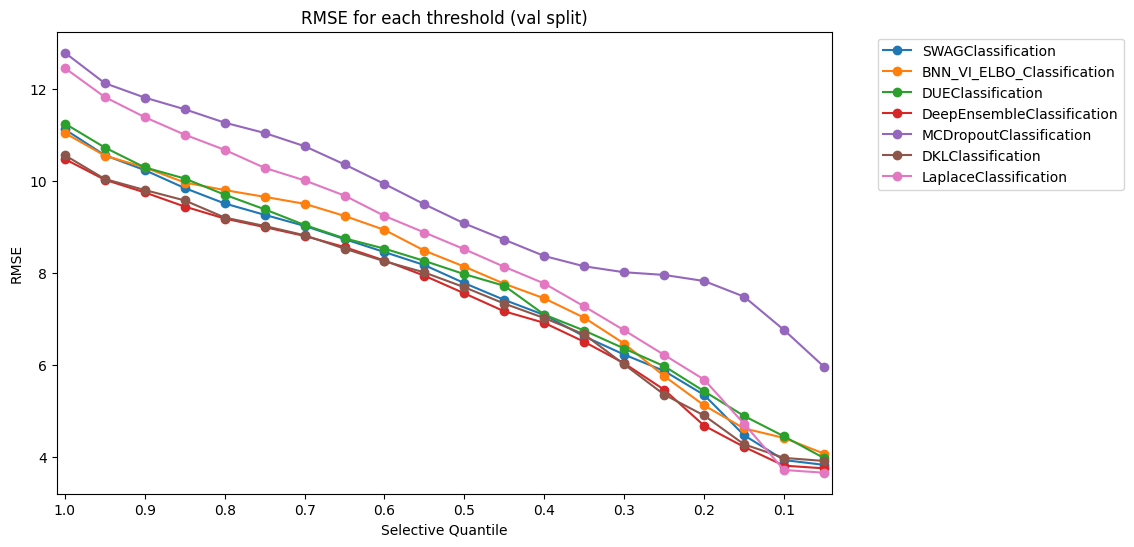

In [ ]:
import matplotlib.pyplot as plt


def plot_rmse(rmse_df, DS_SPLIT):
    # Filter the DataFrame for the given DS_SPLIT
    split_df = rmse_df[rmse_df["split"] == f"preds_{DS_SPLIT}"]

    # Get the unique pred_paths
    pred_paths = split_df["pred_path"].unique()

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot a line for each pred_path
    for pred_path in pred_paths:
        path_df = split_df[split_df["pred_path"] == pred_path]
        method = path_df["uqmethod"].iloc[0]
        path_df = path_df.sort_values("threshold", ascending=False)
        if any(
            condition in pred_path for condition in ["Regression", "ConformalQR", "DER"]
        ):
            marker = "v-"
        else:
            marker = "o-"
        plt.plot(path_df["threshold"], path_df["RMSE"], marker, label=method)

    # Add labels and title
    plt.xlim(max(path_df["threshold"]) + 0.01, min(path_df["threshold"]) - 0.01)
    start, end = plt.xlim()
    plt.xticks(
        np.arange(max(path_df["threshold"]), min(path_df["threshold"]), step=-0.1)
    )  # adjust the step size as needed
    plt.xlabel("Selective Quantile")
    plt.ylabel("RMSE")
    plt.title(f"RMSE for each threshold ({DS_SPLIT} split)")

    # Add a legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Show the plot
    plt.show()


# Call the function
to_plot_df = rmse_df[
    rmse_df["uqmethod"].isin(
        [
            "BNN_VI_ELBO_Classification",
            "BNN_VI_ELBO_Regression",
            "MCDropoutClassification",
            "MCDropoutRegression",
            "DKLClassification",
            "DKLRegression",
            "DUEClassification",
            "DUERegression",
            "DeepEnsembleClassification",
            "DeepEnsembleRegression",
            "SWAGClassification",
            "SWAGRegression",
            "LaplaceClassification",
            "LaplaceRegression",
        ]
    )
]
plot_rmse(to_plot_df, "val")

In [ ]:
mask = (to_plot_df["split"] == "preds_test") & (to_plot_df["threshold"] == 0.8)
to_plot_df_copy09 = to_plot_df.copy()
to_plot_df_copy09 = to_plot_df_copy09[mask]
to_plot_df_copy09

,pred_path,threshold,RMSE,split,uqmethod
24,/p/project/hai_uqmethodbox/experiment_output/c...,0.8,8.881770,preds_test,SWAGClassification
84,/p/project/hai_uqmethodbox/experiment_output/c...,0.8,9.434211,preds_test,BNN_VI_ELBO_Classification
144,/p/project/hai_uqmethodbox/experiment_output/c...,0.8,8.927993,preds_test,DUEClassification
204,/p/project/hai_uqmethodbox/experiment_output/c...,0.8,13.231492,preds_test,DeepEnsembleClassification
264,/p/project/hai_uqmethodbox/experiment_output/c...,0.8,10.699309,preds_test,MCDropoutClassification
324,/p/project/hai_uqmethodbox/experiment_output/c...,0.8,8.695213,preds_test,DKLClassification
384,/p/project/hai_uqmethodbox/experiment_output/c...,0.8,10.073393,preds_test,LaplaceClassification


In [ ]:
mask = (to_plot_df["split"] == "preds_test") & (to_plot_df["threshold"] == 1.0)
to_plot_df_copy1 = to_plot_df.copy()
to_plot_df_copy1 = to_plot_df_copy1[mask]
to_plot_df_copy1

,pred_path,threshold,RMSE,split,uqmethod
20,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,10.444904,preds_test,SWAGClassification
80,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,10.807539,preds_test,BNN_VI_ELBO_Classification
140,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,10.156284,preds_test,DUEClassification
200,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,18.505522,preds_test,DeepEnsembleClassification
260,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,11.955213,preds_test,MCDropoutClassification
320,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,9.596852,preds_test,DKLClassification
380,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,11.477555,preds_test,LaplaceClassification


In [ ]:
to_plot_df_copy1["RMSE"].to_numpy() - to_plot_df_copy09["RMSE"].to_numpy()

array([1.56313407, 1.37332788, 1.22829135, 5.27402982, 1.25590409,
       0.901639  , 1.40416243])

In [ ]:
to_plot_dfdelta = to_plot_df.copy()
to_plot_dfdelta = to_plot_dfdelta[mask]
to_plot_dfdelta["RMSE"] = to_plot_df_copy1["RMSE"].subtract(to_plot_df_copy09["RMSE"])
to_plot_dfdelta

,pred_path,threshold,RMSE,split,uqmethod
20,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,NaN,preds_test,SWAGClassification
80,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,NaN,preds_test,BNN_VI_ELBO_Classification
140,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,NaN,preds_test,DUEClassification
200,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,NaN,preds_test,DeepEnsembleClassification
260,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,NaN,preds_test,MCDropoutClassification
320,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,NaN,preds_test,DKLClassification
380,/p/project/hai_uqmethodbox/experiment_output/c...,1.0,NaN,preds_test,LaplaceClassification


(array([6.7940e+03, 6.8080e+03, 0.0000e+00, 5.6290e+03, 3.2155e+04,
        0.0000e+00, 1.3840e+03, 0.0000e+00, 3.3860e+03, 2.2263e+04,
        0.0000e+00, 2.0200e+03, 0.0000e+00, 6.4900e+03, 8.4490e+03,
        0.0000e+00, 9.3900e+02, 0.0000e+00, 1.8510e+03, 1.4000e+01,
        0.0000e+00, 3.5800e+03, 0.0000e+00, 2.2300e+02, 2.3700e+02,
        0.0000e+00, 5.2640e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.9760e+03, 0.0000e+00, 7.8100e+02, 4.0000e+00,
        0.0000e+00, 3.0000e+00, 6.8000e+01]),
 array([ 4.        ,  4.60526316,  5.21052632,  5.81578947,  6.42105263,
         7.02631579,  7.63157895,  8.23684211,  8.84210526,  9.44736842,
        10.05263158, 10.65789474, 11.26315789, 11.86842105, 12.47368421,
        13.07894737, 13.68421053, 14.28947368, 14.89473684, 15.5       ,
        16.10526316, 16.71052632, 17.31578947, 17.92105263, 18.52631579,
        19.13157895, 19.73684211, 20.34210526, 20.94736842, 21.55263158,
        22.15789474, 22.76315789, 23.368

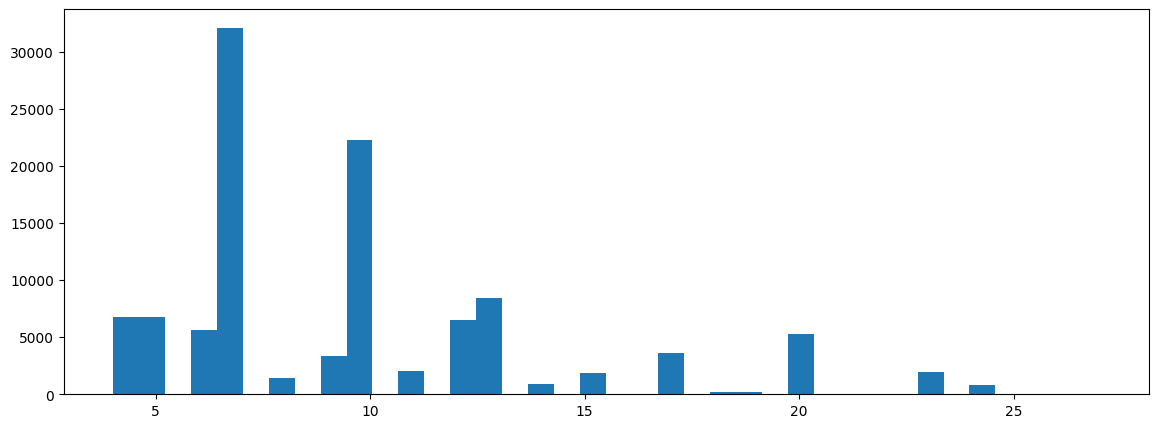

In [ ]:
plt.hist(all_test_pred_df[all_test_pred_df["uqmethod"] == "MCDropoutClassification"]["pred"], bins=38)

3.23566343e-108


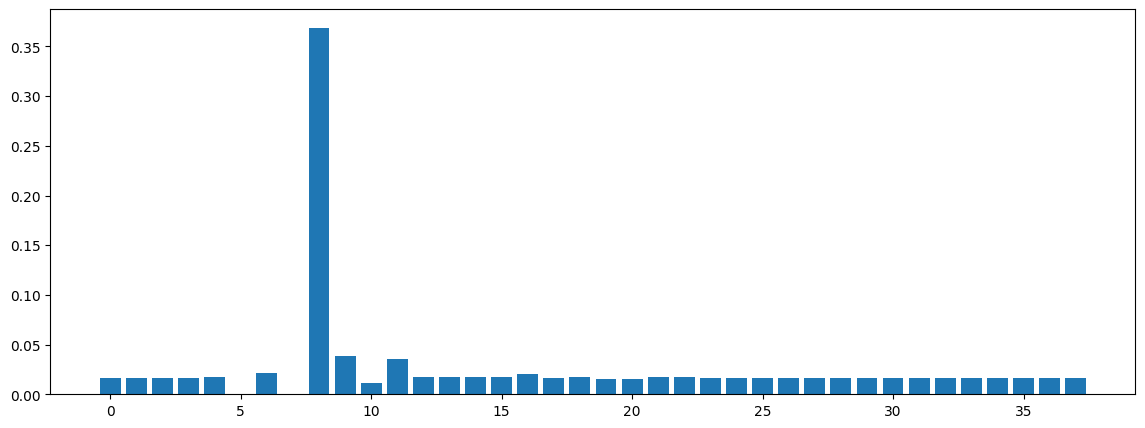

In [ ]:
x = np.array(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
        35,
        36,
        37,
    ]
)

y = np.array(
    [
        1.68090051e-002,
        1.67928561e-002,
        1.67054768e-002,
        1.62813903e-002,
        1.69944308e-002,
        1.66913145e-004,
        2.11623179e-002,
        3.23566343e-108,
        3.68983741e-001,
        3.87836092e-002,
        1.15981540e-002,
        3.55763640e-002,
        1.69406336e-002,
        1.78081482e-002,
        1.71844463e-002,
        1.70356124e-002,
        2.02455483e-002,
        1.68525124e-002,
        1.78657433e-002,
        1.55655203e-002,
        1.49664008e-002,
        1.71864176e-002,
        1.75453737e-002,
        1.66221031e-002,
        1.68487975e-002,
        1.63303458e-002,
        1.68074598e-002,
        1.67049486e-002,
        1.67528557e-002,
        1.67352082e-002,
        1.67640636e-002,
        1.67377197e-002,
        1.67986213e-002,
        1.67498594e-002,
        1.67147277e-002,
        1.67891483e-002,
        1.68202071e-002,
        1.67733193e-002,
    ]
)

fig, ax = plt.subplots()
ax.bar(x, y, label="data")
print(y[7])

5 5.025021354893159


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


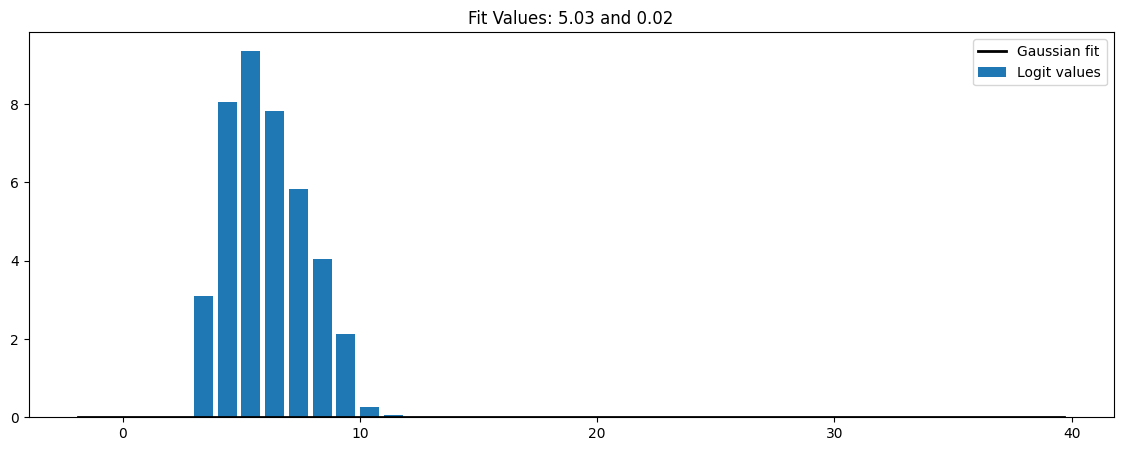

In [ ]:
logit_cols = [col for col in all_test_pred_df.columns if col.startswith("logit_")]

# Compute softmax values for each logit
# exp_logits = np.exp(all_test_pred_df[logit_cols].values)
# softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
logits = all_test_pred_df[logit_cols].values

logits_softplus = np.log1p(np.exp(logits))

bin_intervals = np.diff(WIND_SPEED_BINS) / 2
bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

# Select the first row of softmax values
softplus_row = logits_softplus[20, :]

from scipy.optimize import curve_fit


# Define a Gaussian function
def gaussian(x, mu, std):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std) ** 2)


# Fit a Gaussian to the softmax values
popt, pcov = curve_fit(gaussian, np.arange(len(softplus_row)), softplus_row, p0=[0, 1])

# Extract the fitted parameters
mu, std = popt

# Plot the softmax values as a bar plot
plt.bar(np.arange(len(softplus_row)), softplus_row, align="edge", label="Logit values")

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gaussian(x, mu, std)
plt.plot(x, p, "k", linewidth=2, label="Gaussian fit")

# Add a title and legend
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.legend()

print(np.argmax(softplus_row), mu)
# Display the plot
plt.show()

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,logit_36,logit_37,uqmethod,split,pred_path,relative_time,ocean,date,argmax_reg,softmax_weighted_reg
561925,5,1.309181,6,acd,0,33,0.000016,0.000016,0.000016,0.005847,...,0.000016,0.000016,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,307798.0,1.0,NaT,27.5,30.152882
561926,5,1.312035,6,acd,1,33,0.000016,0.000016,0.000016,0.005768,...,0.000017,0.000016,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,309598.0,1.0,NaT,27.5,30.192694
561927,5,1.221888,6,acd,2,32,0.000029,0.000029,0.000029,0.013380,...,0.000029,0.000029,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,313198.0,1.0,NaT,27.5,28.378984
561928,5,1.197257,6,acd,3,32,0.000083,0.000083,0.000083,0.031726,...,0.000085,0.000083,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,314998.0,1.0,NaT,27.5,26.785273
561929,5,1.234924,6,acd,4,31,0.000032,0.000032,0.000033,0.013476,...,0.000033,0.000033,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,316799.0,1.0,NaT,27.5,28.466921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605555,4,1.236866,4,zza,43630,20,0.001335,0.001286,0.001306,0.133363,...,0.001300,0.001282,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,378002.0,1.0,NaT,22.5,25.270188
605556,4,1.309053,4,zza,43631,20,0.002320,0.002230,0.002263,0.156707,...,0.002243,0.002218,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,379802.0,1.0,NaT,22.5,26.259762
605557,4,1.263098,4,zza,43632,20,0.001645,0.001577,0.001605,0.140719,...,0.001591,0.001575,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,381602.0,1.0,NaT,22.5,25.569041
605558,4,1.298882,4,zza,43633,20,0.002120,0.002034,0.002064,0.151415,...,0.002045,0.002026,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,383402.0,1.0,NaT,22.5,26.057234


count    43635.000000
mean         1.826970
std          0.416352
min          1.178031
25%          1.451511
50%          1.860127
75%          2.159141
max          3.286030
Name: pred_uct, dtype: float64


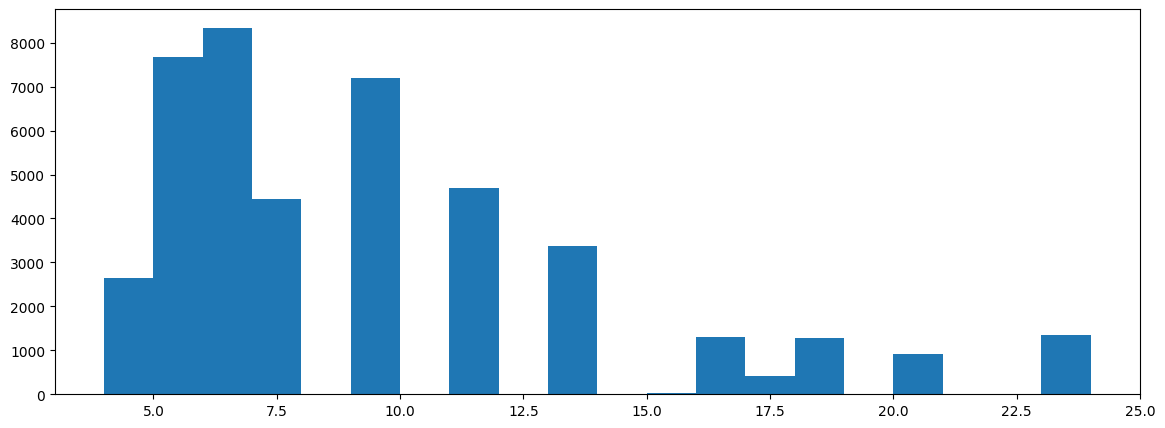

In [ ]:
with pd.option_context("display.max_colwidth", None):
    df = all_test_pred_df[
        (all_test_pred_df["uqmethod"] == "DKLClassification")
        & (all_test_pred_df["split"] == "preds_test")
    ]
    display(df)
    fig, ax = plt.subplots(1)
    ax.hist(df["pred"], bins=20, label="target")
    print(df["pred_uct"].describe())
    plt.show()

In [ ]:
def compute_metrics(df, pred_col: str):
    df["mse"] = (df[pred_col] - df["wind_speed"]) ** 2
    df["mae"] = np.abs(df[pred_col] - df["wind_speed"])
    metric_df = (
        df.groupby(["uqmethod", "split", "pred_path"])
        .agg({"mse": "mean", "mae": "mean"})
        .reset_index()
    )
    metric_df["rmse"] = metric_df["mse"].apply(np.sqrt)
    return metric_df


# choose over which pred type column to compute the metrics
with pd.option_context("display.max_colwidth", None):
    display(compute_metrics(all_test_pred_df, "argmax_reg"))

,uqmethod,split,pred_path,mse,mae,rmse
0,BNN_VI_ELBO_Classification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_test.csv,116.802905,7.994443,10.807539
1,BNN_VI_ELBO_Classification,preds_train,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_train.csv,89.653315,6.947984,9.468543
2,BNN_VI_ELBO_Classification,preds_val,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_val.csv,122.058805,8.150314,11.048023
3,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_test.csv,92.099570,7.167652,9.596852
4,DKLClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_train.csv,70.920263,6.348406,8.421417
5,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DKLClassification_02-26-2024_21-08-45-497211/preds_val.csv,111.648549,7.788050,10.566388
6,DUEClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_test.csv,103.150103,7.517188,10.156284
7,DUEClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_train.csv,81.452137,6.741233,9.025084
8,DUEClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_val.csv,126.639357,8.272327,11.253415
9,DeepEnsembleClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DeepEnsembleClassification_02-28-2024_13-55-54-990701/preds_test.csv,342.454331,12.907929,18.505522


        pred  pred_uct  target storm_id  index  wind_speed   logit_0  \
272893     5   1.16492       6      yuo  41922          30  0.000001   

             logit_1       logit_2   logit_3  ...           uqmethod  \
272893  9.634507e-07  9.350820e-07  0.002063  ...  DUEClassification   

             split                                          pred_path  \
272893  preds_test  /p/project/hai_uqmethodbox/experiment_output/c...   

        relative_time  ocean  date  argmax_reg  softmax_weighted_reg   mse  \
272893       156602.0    2.0   NaT        27.5             29.792067  6.25   

        mae  
272893  2.5  

[1 rows x 54 columns]
41922


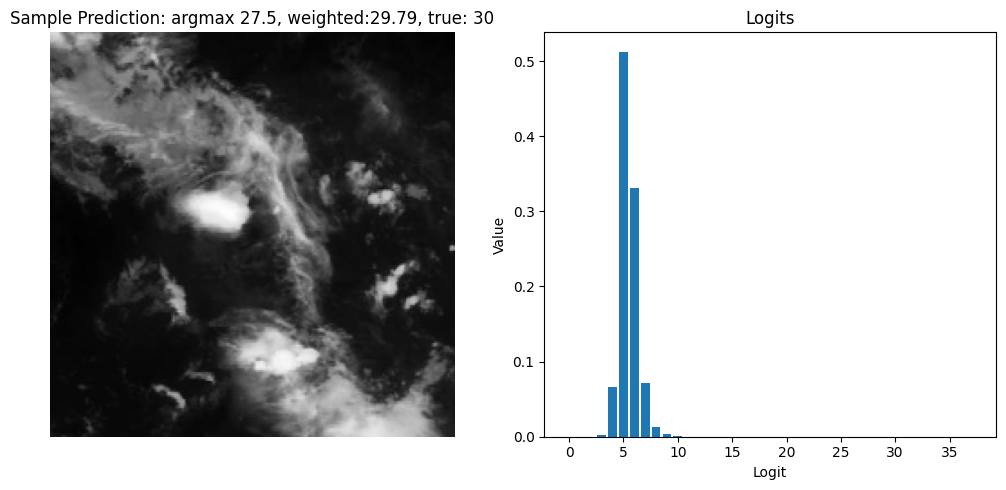

In [ ]:
import matplotlib.pyplot as plt


def plot_method(all_test_pred_df, method: str, data_split: str):
    # Select rows for the given method
    df_method = all_test_pred_df[all_test_pred_df["uqmethod"] == method]
    df_method = df_method[df_method["split"] == f"preds_{data_split}"]

    # If there's no data for the given method, return
    if df_method.empty:
        print(f"No data for method: {method}")
        return

    # Select a random row (sample) from the dataframe
    sample = df_method.sample(1)

    # Extract logit columns (columns that start with 'logt_')
    logit_cols = [col for col in df_method.columns if col.startswith("logit_")]
    logits = sample[logit_cols].values[0]

    # Create a figure with two subplots: one for the prediction, one for the logits
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    print(sample)
    print(sample["index"].iloc[0])
    img = DS_DICT[data_split][int(sample["index"].iloc[0])]["input"]
    # Plot prediction
    axs[0].imshow(img[0, ...], cmap="gray")
    axs[0].set_title(
        f'Sample Prediction: argmax {sample["argmax_reg"].iloc[0]}, weighted:{sample["softmax_weighted_reg"].iloc[0]:.2f}, true: {sample["wind_speed"].iloc[0]}'
    )
    axs[0].set_xlabel("Index")
    axs[0].axis("off")
    axs[0].set_ylabel("Prediction")

    # Plot logits
    axs[1].bar(range(len(logit_cols)), logits)
    axs[1].set_title("Logits")
    axs[1].set_xlabel("Logit")
    axs[1].set_ylabel("Value")

    # Display the plot
    plt.tight_layout()
    plt.show()


plot_method(all_test_pred_df, "DUEClassification", DS_SPLIT)

In [ ]:
metric_df

NameError: name 'metric_df' is not defined

In [ ]:
def compute_metrics_for_predictions_wrapper(path, selective_pred, normalised):
    try:
        return compute_metrics_for_predictions(path, selective_pred, normalised)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_uncertainty_df(overview_df):
    def parallel_process(
        paths: List[str], num_processes: int, selective_pred: bool, normalised: bool
    ):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        # result_dfs = pool.starmap(compute_metrics_for_predictions, [(path, selective_pred, normalised) for path in paths])
        results = pool.starmap(
            compute_metrics_for_predictions_wrapper,
            [(path, selective_pred, normalised) for path in paths],
        )
        # Filter out None results
        result_dfs = [result for result in results if result is not None]
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        combined_df = pd.concat(result_dfs, ignore_index=True)
        return combined_df

    # Assuming 'df' is your original DataFrame with the path column
    # Extract the paths from the DataFrame column
    paths = overview_df["pred_path"].tolist()

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities

    # Call the parallel_process function to execute the processing in parallel
    uqmetric_df = parallel_process(
        paths, num_processes, selective_pred=False, normalised=False
    )
    selective_df = parallel_process(
        paths, num_processes, selective_pred=True, normalised=False
    )

    # merge model name column
    uqmetric_df = pd.merge(
        left=uqmetric_df,
        right=overview_df[["pred_path", "uqmethod"]],
        how="left",
        left_on="pred_path",
        right_on="pred_path",
    )
    selective_df = pd.merge(
        left=selective_df,
        right=overview_df[["pred_path", "uqmethod"]],
        how="left",
        left_on="pred_path",
        right_on="pred_path",
    )

    return uqmetric_df, selective_df


uq_metric_df, selective_df = compute_uncertainty_df(overview_df)

uq_metric_df, selective_df

Error processing /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv: name 'compute_metrics_for_predictions' is not definedError processing /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_val.csv: name 'compute_metrics_for_predictions' is not definedError processing /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_val.csv: name 'compute_metrics_for_predictions' is not definedError processing /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_BNN_VI_ELBO_Classification_02-23-2024_13-47-34-548274/preds_test.csv: name 'compute_metrics_for_predictions' is not definedError processing /p/project/hai_uqmethodbox/experiment_output/class_min_speed_0/cyclone_DUEClassification_02-26-2024_21-08-45-497203/preds_test.csv: name 'compute_metrics_for_p

ValueError: No objects to concatenate

In [ ]:
def generate_latex_table(uq_metric_df, selective_df, split_type):
    category_columns = ["rmse", "crps", "nll", "ma_cal"]
    # table_columns = ["default", "diff"]
    # columns = pd.MultiIndex.from_product(
    #     [["default", "diff"]]
    # )
    combined_df = pd.DataFrame(columns=category_columns)

    table_uq_df = uq_metric_df[uq_metric_df["split"] == f"preds_{split_type}"]
    table_selective_df = selective_df[selective_df["split"] == f"preds_{split_type}"]

    table_uq_df["uqmethod"] = pd.Categorical(
        table_uq_df["uqmethod"], categories=UQ_METHOD_DISPLAY_ORDER, ordered=True
    )

    for metric in category_columns:
        # combined_df[(split_type, metric, "selective")] = table_selective_df[metric]
        combined_df[(metric)] = table_uq_df[metric]
        if "rmse" == metric:
            diff_rmse = table_uq_df[metric] - table_selective_df[metric]
            combined_df.insert(
                combined_df.columns.get_loc(metric) + 1, "diff rmse", diff_rmse
            )
            coverage = table_selective_df["count_total"] / table_uq_df["count_total"]
            combined_df.insert(
                combined_df.columns.get_loc("diff rmse") + 1, "coverage", coverage
            )

    combined_df.insert(0, ("uqmethod"), table_uq_df["uqmethod"])
    combined_df = combined_df.round(2)

    combined_df = combined_df.sort_values("uqmethod")

    # Add a new column for the groups
    combined_df["group"] = combined_df["uqmethod"].apply(
        lambda x: next((k for k, v in UQ_METHOD_GROUPS.items() if x in v), "None")
    )

    # Move the group column to the front
    combined_df = combined_df[
        ["group"] + [col for col in combined_df.columns if col != "group"]
    ]

    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    combined_df["uqmethod"] = combined_df["uqmethod"].apply(
        lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x
    )

    print(combined_df)
    latex_table = as_latex_output(combined_df, category_columns)
    return latex_table


def as_latex_output(combined_df, category_columns):
    """Format latex output"""
    combined_df = combined_df.round(4)
    max_values = combined_df.max()
    min_values = combined_df.min()

    # Replace the group names with the \multirow command
    for group in UQ_METHOD_GROUPS.keys():
        num_rows = len(combined_df[combined_df["group"] == group])
        group_indices = combined_df[combined_df["group"] == group].index
        if len(group_indices) > 0:
            first_index = group_indices[0]
            combined_df.at[first_index, "group"] = (
                r"\multirow{" + str(num_rows) + "}{*}{" + group + "}"
            )
            for index in group_indices[1:]:
                combined_df.at[index, "group"] = ""

    # convert to latex
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.2f")

    # bold face column values
    min_cols = ["rmse", "crps", "nll", "ma_cal"]
    max_cols = ["diff rmse", "coverage"]
    for column in max_values.index:
        if column in max_cols:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        elif column in min_cols:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        else:
            continue

    # Replace the category_columns values using the VAR_TO_PLOT_LABEL dictionary
    for column in category_columns:
        latex_output = latex_output.replace(
            column, VAR_TO_PLOT_LABEL[column] if column in VAR_TO_PLOT_LABEL else column
        )

    # other formatting
    # latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\\multirow", "\\midrule\n\\multirow")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("RMSE", "RMSE $\downarrow$")
    latex_output = latex_output.replace(
        "diff RMSE $\downarrow$", r"RMSE $\Delta$ $\uparrow$"
    )
    latex_output = latex_output.replace("NLL", "NLL $\downarrow$")
    latex_output = latex_output.replace("ma_cal", "MACE $\downarrow$")
    latex_output = latex_output.replace("coverage", r"Coverage $\uparrow$")
    latex_output = latex_output.replace("CRPS", "CRPS $\downarrow$")

    latex_output = latex_output.replace("group", "UQ group")
    latex_output = latex_output.replace("uqmethod", "Method")

    return latex_output


latex_table = generate_latex_table(uq_metric_df, selective_df, DS_SPLIT)
print(latex_table)